In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import src.metrics as metrics

In [2]:
np.random.seed(1)

In [5]:
def test_PairwiseNorm():
    xx = np.random.normal(size=(3, 2))
    yy = np.random.normal(size=(3, 2))

    pn = metrics.PairwiseNorm(p=2)
    nn = pn(xx, yy)

    for i in range(3):
        for j in range(3):
            nn2 = np.linalg.norm(xx[i] - yy[j], ord=2)
            assert np.allclose(nn[i, j], nn2)


test_PairwiseNorm()

In [6]:
n = 1000

In [7]:
xx = np.random.normal(size=(n, 2))
yy = np.random.normal(size=(n, 2))


In [8]:
ed = metrics.EnergyDistance()

ed(xx, yy)

-0.0006323507731893496

In [9]:
ged = metrics.GeneralisedEnergyDistance(dim=xx.shape[-1])

ged(xx, yy)

-0.0006323507731893496

In [10]:
# groups = [[i] for i in range(2)]
# groups = [range(2)]
ged = metrics.GeneralisedEnergyDistance(base_metric="l2", dim=xx.shape[-1])

ged(xx, yy)

-0.0002123862337710669

# Reproduce the incapability of ED to distinguish the full cov matrix and the capability of GED

In [55]:
def generate_gauss(d):
    diag = np.linspace(1., d, d)**0.2

    cov_mat1 = np.eye(d)
    np.fill_diagonal(cov_mat1, diag)
    L1 = np.linalg.cholesky(cov_mat1)

    cov_mat2 = np.eye(d)
    np.fill_diagonal(cov_mat2, diag[::-1])
    L2 = np.linalg.cholesky(cov_mat2)
    
    xx = np.matmul(np.random.normal(size=(n, d)), L1)
    yy = np.matmul(np.random.normal(size=(n, d)), L2)

    return xx, yy

def run_experiment(dims, generate_fn, name_generator_pairs, n=1000):
    res = {s: [] for s, _ in name_generator_pairs.items()}
    
    for d in tqdm(dims):
        xx, yy = generate_fn(d)
        
        for name, generator in name_generator_pairs.items():
            metric = generator(d)
            res[name].append(metric(xx, yy))

        # # ED
        # res["ed_list"].append(ed(xx, yy))

        # # GED with correct grouping
        # # groups = [range(d)]
        # ged = metrics.GeneralisedEnergyDistance(base_metric="l2", dim=d)
        # res["ged_list"].append(ged(xx, yy))

        # # GED with correct block diag grouping
        # groups = [[2*i, 2*i + 1] for i in range(d//2)]
        # print("groups", groups)
        # ged = metrics.GeneralisedEnergyDistance(base_metric="l2", groups=groups)
        # res["ged_block_list"].append(ged(xx, yy))

        # # GED with correct sparse grouping
        # groups = [[0, 1], [i for i in range(2, d)]]
        # print("groups", groups)
        # ged = metrics.GeneralisedEnergyDistance(base_metric="l2", groups=groups)
        # res["ged_correct_list"].append(ged(xx, yy))

    return res

In [61]:
dims = [2, 10, 20, 50, 100, 200, 500]
n = 1000

In [47]:
res = run_experiment(dims=dims, n=n, generate_fn=generate_gauss)

In [12]:
def plot_experiment(dims, res):
    nres = len(res)
    figs, axes = plt.subplots(1, nres, figsize=(5*nres, 5))

    for i, (k, v) in enumerate(res.items()):
        if v != []:
            axes[i].plot(dims, v, label=k)
            axes[i].legend()

In [ ]:
plot_experiment(dims, res)

# Block diagonal cov matrix

In [48]:
def generate_gauss_block(d):
    cov_mat1_2d = np.eye(2)
    cov_mat1_2d[0, 1], cov_mat1_2d[1, 0] = 0.5, 0.5
    cov_mat1_4d = scipy.linalg.block_diag(cov_mat1_2d, cov_mat1_2d)
    cov_mat1_4d[0, 3], cov_mat1_4d[3, 0] = 0.5, 0.5
    cov_mat1 = scipy.linalg.block_diag(*[cov_mat1_4d]*(d//4))

    L1 = np.linalg.cholesky(cov_mat1)

    cov_mat2_2d = cov_mat1_2d
    cov_mat2 = scipy.linalg.block_diag(*[cov_mat2_2d]*(d//2))

    L2 = np.linalg.cholesky(cov_mat2)
    
    xx = np.matmul(np.random.normal(size=(n, d)), L1.T)
    yy = np.matmul(np.random.normal(size=(n, d)), L2.T)

    return xx, yy

def generate_gauss_block_identical(d):
    cov_mat1_2d = np.eye(2)
    cov_mat1_2d[0, 1], cov_mat1_2d[1, 0] = 0.5, 0.5
    cov_mat1_4d = scipy.linalg.block_diag(cov_mat1_2d, cov_mat1_2d)
    cov_mat1_4d[0, 3], cov_mat1_4d[3, 0] = 0.5, 0.5
    cov_mat1 = scipy.linalg.block_diag(*[cov_mat1_4d]*(d//4))

    L1 = np.linalg.cholesky(cov_mat1)
    
    xx = np.matmul(np.random.normal(size=(n, d)), L1.T)
    yy = np.matmul(np.random.normal(size=(n, d)), L1.T)

    return xx, yy

In [64]:
def initialise_metric_ed(d):
    # ED
    ged = metrics.GeneralisedEnergyDistance(dim=d)
    return ged

def initialise_metric_default_l2(d):
    # GED with default grouping
    ged = metrics.GeneralisedEnergyDistance(base_metric="l2", dim=d)
    return ged

def initialise_metric_pairwise(d):
    # GED with pairwise block diag grouping
    groups = [[2*i, 2*i + 1] for i in range(d//2)]
    ged = metrics.GeneralisedEnergyDistance(base_metric="l2", groups=groups)
    return ged

def initialise_metric_every_four(d):
    # GED with every four coordinates grouped together
    # and the rest are grouped together
    groups = [[4*i, 4*i + 3] for i in range(d//4)]
    groups_collapsed = [i for g in groups for i in g]
    groups += [[i for i in range(d) if i not in groups_collapsed]]
    ged = metrics.GeneralisedEnergyDistance(base_metric="l2", groups=groups)
    return ged

In [62]:
dims = [4, 52, 100, 200, 500, 1000, 2000]

In [63]:
res = run_experiment(
    dims=dims, 
    n=500, 
    generate_fn=generate_gauss_block,
    # generate_fn=generate_gauss_block_identical,
    name_generator_pairs={
        "ed": initialise_metric_ed,
        "default": initialise_metric_default_l2,
        "pairwise": initialise_metric_pairwise,
        "every_four": initialise_metric_every_four,
    }
)

  0%|          | 0/7 [00:00<?, ?it/s]

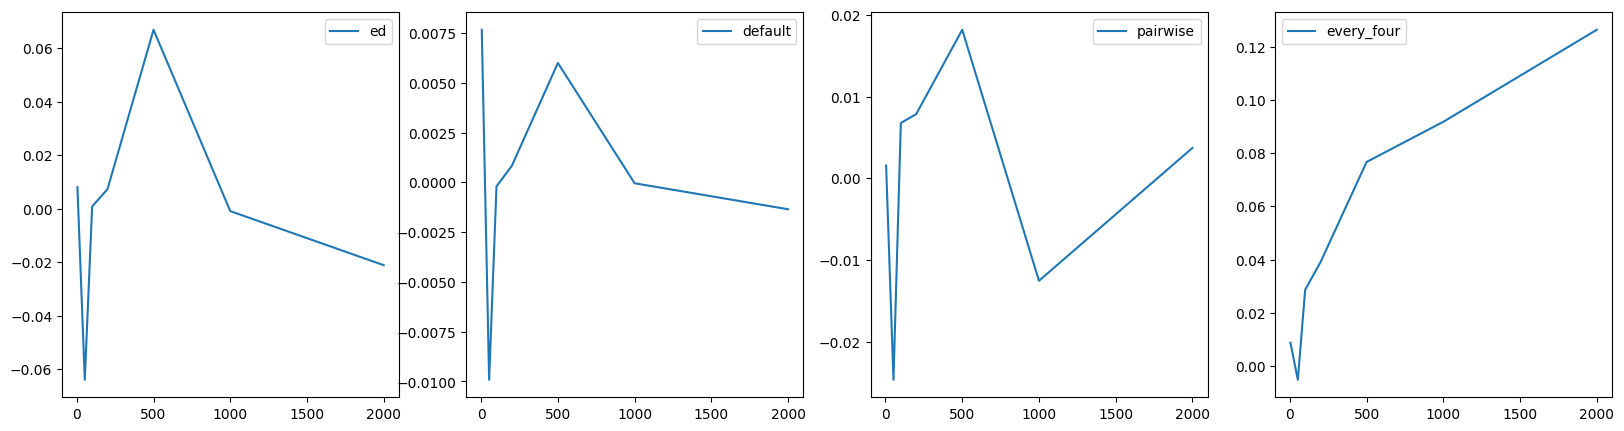

In [60]:
plot_experiment(dims, res)

# Sparse distributions

In [100]:
def generate_gauss_sparse(d):
    diag1 = np.ones((d,))
    diag1[:2] = [4., 2.]

    diag2 = np.ones((d,))
    diag2[:2] = diag1[:2][::-1]

    cov_mat1 = np.eye(d)
    np.fill_diagonal(cov_mat1, diag1)
    L1 = np.linalg.cholesky(cov_mat1)

    cov_mat2 = np.eye(d)
    np.fill_diagonal(cov_mat2, diag2)
    L2 = np.linalg.cholesky(cov_mat2)
    
    xx = np.matmul(np.random.normal(size=(n, d)), L1.T)
    yy = np.matmul(np.random.normal(size=(n, d)), L2.T)

    return xx, yy

In [113]:
dd = 10

groups = [[0, 1], [i for i in range(2, dd)]]
ged = metrics.GeneralisedEnergyDistance(base_metric="l2", groups=groups)

xx = np.random.normal(size=(n, dd))
yy = np.random.normal(size=(n, dd))
ged(xx, yy)

[0, 1]
[2, 3, 4, 5, 6, 7, 8, 9]
[0, 1]
[2, 3, 4, 5, 6, 7, 8, 9]
[0, 1]
[2, 3, 4, 5, 6, 7, 8, 9]


-0.0003638252599924563

In [115]:
res = run_experiment(dims=dims, n=n, generate_fn=generate_gauss_sparse)

  0%|          | 0/7 [00:00<?, ?it/s]

[0]
[1]
[0]
[1]
[0]
[1]
[0, 1]
[]
[0, 1]
[]
[0, 1]
[]
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[0, 1]
[2, 3, 4, 5, 6, 7, 8, 9]
[0, 1]
[2, 3, 4, 5, 6, 7, 8, 9]
[0, 1]
[2, 3, 4, 5, 6, 7, 8, 9]
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[0, 1]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 1]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 1]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]

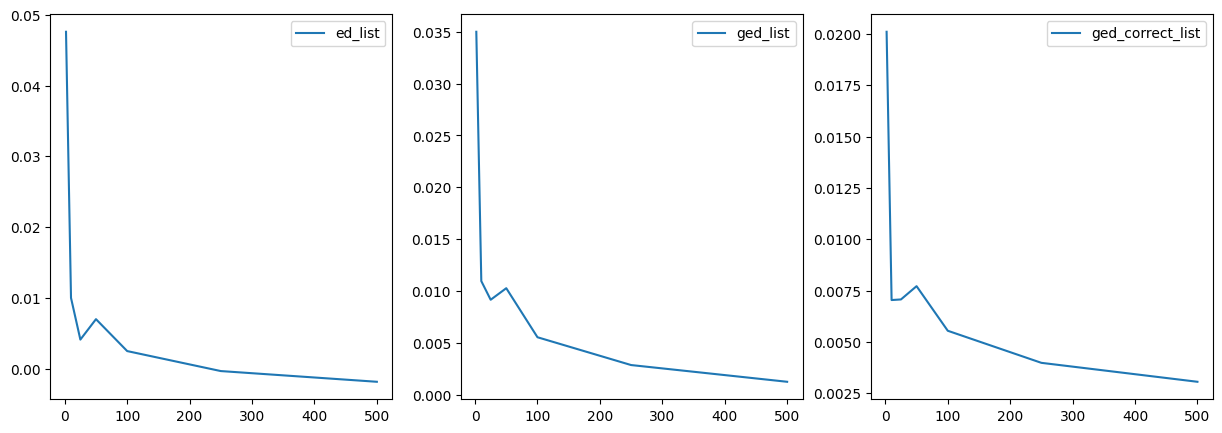

In [116]:
plot_experiment(dims, res)